In [1]:
# Importing modules
import pandas as pd
import numpy as np

data = pd.read_csv('netflix_titles.csv')# Print head
data.head()

show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021          2021  TV-MA   1 Season   
3  September 24, 2021          2021  TV-MA   1 Season   
4  September 24, 2021          2021  TV-MA  2 Seasons   

                                           listed_in  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   
3                             Docuseries, Reality TV   
4  International TV Shows, Romantic TV Shows, TV ...   

                                         description  
0  As her father nears the end of his life, filmm...  
1  After crossing paths at a party, a Cape Town t...  
2  To protect his family from a powerful drug lor...  
3  Feuds, flirtations and toilet talk go down amo...  
4  In a city of coaching centers known to train I...

In [2]:
# Load the regular expression library
import re

# Remove punctuation
data['description_processed'] = \
data['description'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
data['description_processed'] = \
data['description_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
data['description_processed'].head()

0    as her father nears the end of his life filmma...
1    after crossing paths at a party a cape town te...
2    to protect his family from a powerful drug lor...
3    feuds flirtations and toilet talk go down amon...
4    in a city of coaching centers known to train i...
Name: description_processed, dtype: object

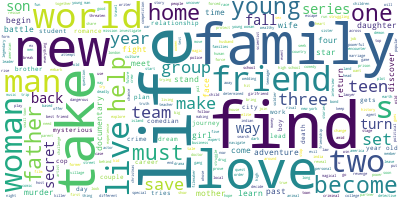

In [3]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(data['description_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [4]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
import gensim.corpora as corpora
from pprint import pprint

stop_words = stopwords.words('english')

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

description_data = data.description_processed.values.tolist()
data_words = list(sent_to_words(description_data))

# remove stop words
data_words = remove_stopwords(data_words)

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

num_topics_list = list(range(51)[1:])
num_keywords = 15


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rongeryang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

## LDA

In [142]:
lda_models = {}
lda_topics = {}
coherence_lda_list = []
perplexity_lda_list = []

for num_topics in num_topics_list:
    # Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           random_state=1,
                                           num_topics=num_topics)
    lda_models[num_topics] = lda_model
    
    #calculating model perplexity
    perplexity_lda_list.append(lda_model.log_perplexity(corpus))
    
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         corpus=corpus,
                                         dictionary=id2word, 
                                         coherence='u_mass')
    coherence_lda_list.append(coherence_model_lda.get_coherence())
    
    shown_topics = lda_model.show_topics(num_topics=num_topics, 
                                             num_words=15,
                                             formatted=False)
    lda_topics[num_topics] = [[word[0] for word in topic[1]] for topic in shown_topics]
    
    print('num_topics:', num_topics, 'coherence lda:', coherence_lda_list[num_topics - 1], 'perplexity lda:', perplexity_lda_list[num_topics - 1])
    
    

num_topics: 1 coherence lda: -3.395889034304105 perplexity lda: -8.743615057895799
num_topics: 2 coherence lda: -3.3206645758608206 perplexity lda: -8.906899652726116
num_topics: 3 coherence lda: -3.443024046291575 perplexity lda: -9.001497343547898
num_topics: 4 coherence lda: -3.5224925849320963 perplexity lda: -9.071068296033074
num_topics: 5 coherence lda: -3.538816729358534 perplexity lda: -9.134509889196172
num_topics: 6 coherence lda: -3.604209515900342 perplexity lda: -9.18899733884244
num_topics: 7 coherence lda: -3.5833658708237555 perplexity lda: -9.233338627203917
num_topics: 8 coherence lda: -3.6595827892005977 perplexity lda: -9.280115947213973
num_topics: 9 coherence lda: -3.6343990648386546 perplexity lda: -9.324462155648142
num_topics: 10 coherence lda: -3.6846047682755816 perplexity lda: -9.360739344196702
num_topics: 11 coherence lda: -3.6219750763013505 perplexity lda: -9.393516470008171
num_topics: 12 coherence lda: -3.627248245847149 perplexity lda: -9.43422221261

In [143]:
# printing model perplexity and coherence lists for lda model
print(perplexity_lda_list)
print(coherence_lda_list)

[-8.743615057895799, -8.906899652726116, -9.001497343547898, -9.071068296033074, -9.134509889196172, -9.18899733884244, -9.233338627203917, -9.280115947213973, -9.324462155648142, -9.360739344196702, -9.393516470008171, -9.434222212617156, -9.467244443670339, -9.495721213400543, -9.531500427028659, -9.566806804957958, -9.590174109173802, -9.614286834042325, -9.644193676163274, -9.672048025829454, -9.690977997942815, -9.711491059177629, -9.741192790996006, -9.770315961048553, -9.786945768116057, -9.81586153402319, -9.836797362080212, -9.857149870839562, -9.866636320255324, -9.89345468619904, -9.904030561651062, -9.924598337277471, -9.944628476337552, -9.95779709291253, -9.97749483191409, -9.992738437578916, -10.008233412152416, -10.036054862580206, -10.045516630650779, -10.056376862378041, -10.068147960556558, -10.090306674251105, -10.099985585701054, -10.119322480708204, -10.131106296298409, -10.147149040754133, -10.160623418852179, -10.17566241864286, -10.184437280126982, -10.20592568

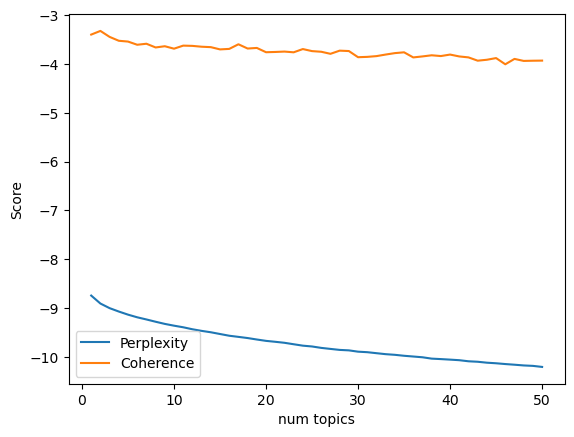

In [144]:
import matplotlib.pyplot as plt 

plt.plot(num_topics_list, perplexity_lda_list, label='Perplexity')
plt.plot(num_topics_list, coherence_lda_list, label='Coherence')
plt.xlabel('num topics')
plt.ylabel('Score')
plt.legend()
plt.show()

In [147]:
lda_stability = {}
for i in range(0, len(num_topics_list)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(lda_topics[num_topics_list[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(lda_topics[num_topics_list[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    lda_stability[num_topics_list[i]] = jaccard_sims
                
mean_stabilities = [np.array(lda_stability[i]).mean() for i in num_topics_list[:-1]]
coh_sta_diffs = [coherence_lda_list[i] - mean_stabilities[i] for i in range(num_topics_list[-1]-1)] # limit topic numbers to the number of keywords
coh_sta_max = min(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics_list[ideal_topic_num_index] + 1
ideal_topic_num

46

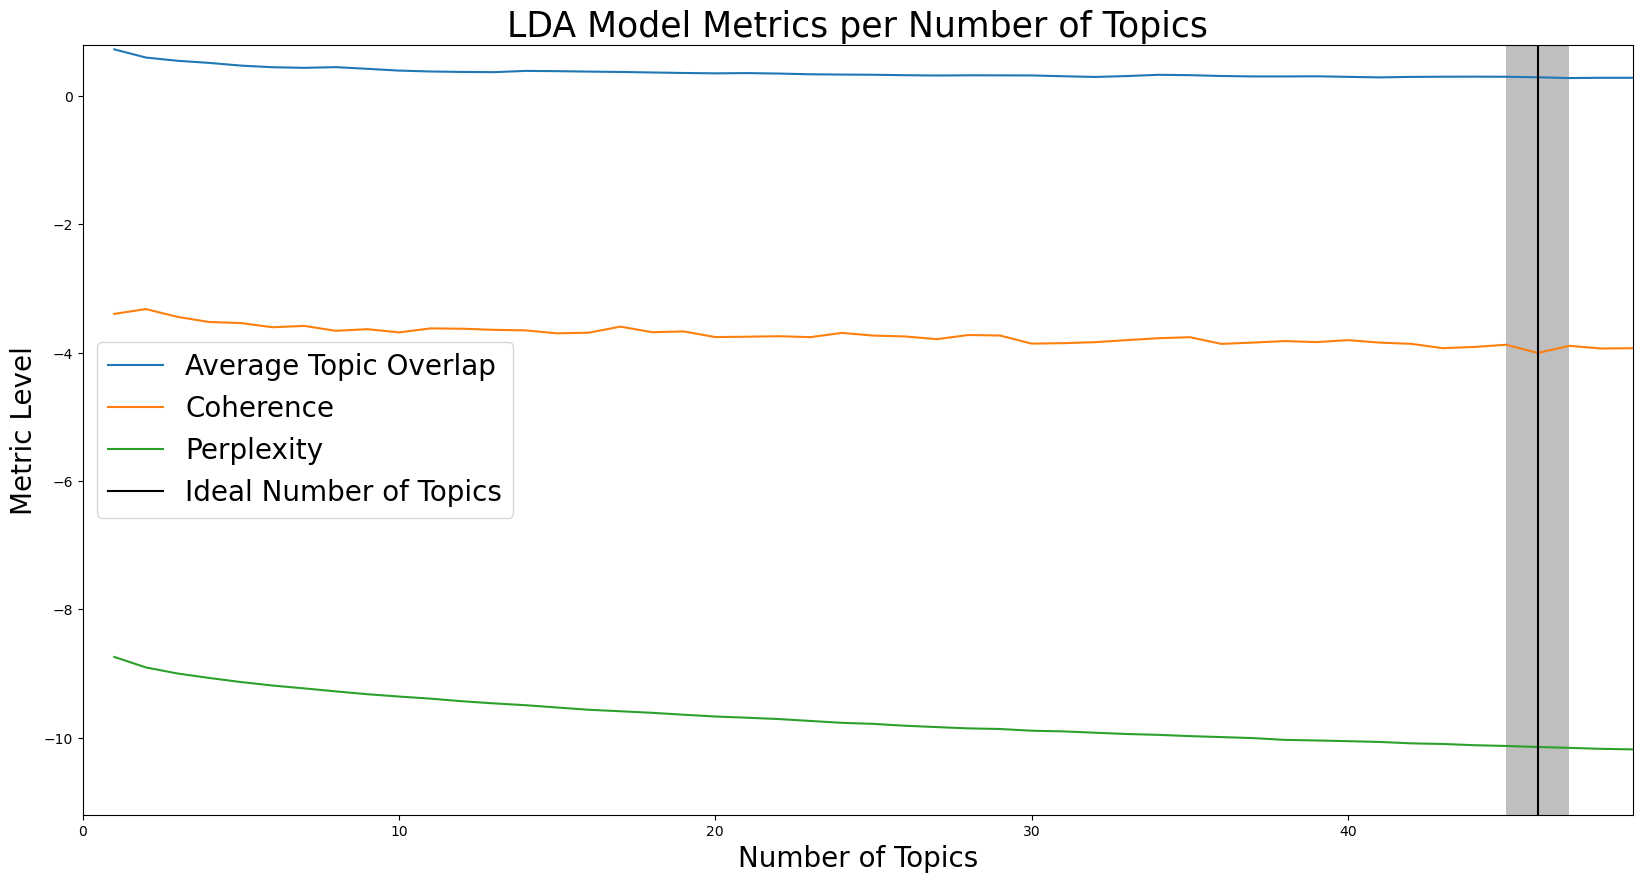

In [146]:
import seaborn as sns

plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics_list[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics_list[:-1], y=coherence_lda_list[:-1], label='Coherence')
ax = sns.lineplot(x=num_topics_list[:-1], y=perplexity_lda_list[:-1], label='Perplexity')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_min = min(min(mean_stabilities), min(coherence_lda_list[:-1]), min(perplexity_lda_list[:-1])) + (0.10 * min(min(mean_stabilities), min(coherence_lda_list[:-1]), min(perplexity_lda_list[:-1])))
y_max = max(max(mean_stabilities), max(coherence_lda_list[:-1])) + (0.10 * max(max(mean_stabilities), max(coherence_lda_list[:-1])))
ax.set_ylim([y_min, y_max])
ax.set_xlim([0, num_topics_list[-1]-1])
                
ax.axes.set_title('LDA Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()   

In [22]:
pip install --upgrade pyLDAvis

  Using cached pyLDAvis-3.3.1-py2.py3-none-any.whl
  Attempting uninstall: pyLDAvis
    Found existing installation: pyLDAvis 2.1.2
    Uninstalling pyLDAvis-2.1.2:
      Successfully uninstalled pyLDAvis-2.1.2
Note: you may need to restart the kernel to use updated packages.


In [23]:
# Assuming best num_topics = 46

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=46)
vis_data = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis_data)

/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  # marginal distribution over terms (width of blue bars)


A lower perplexity score indicates better generalization performance.

## NMF

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim.models import Nmf
from sklearn.feature_extraction import text

from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer

In [7]:
nmf_models = {}
nmf_topics = {}
coherence_nmf_list = []
perplexity_nmf_list = []

for num_topics in num_topics_list:
    # Build NMF model
    nmf = Nmf(
        corpus=corpus,
        num_topics=num_topics,
        id2word=id2word,
        )
    nmf_models[num_topics] = nmf
    
    # Run the coherence model to get the score
    cm = gensim.models.coherencemodel.CoherenceModel(
        corpus=corpus,
        model=nmf,
        dictionary=id2word,
        coherence='u_mass'
    )
    
    coherence_nmf_list.append(cm.get_coherence())

    
    shown_topics = nmf.show_topics(num_topics=num_topics, 
                                             num_words=15,
                                             formatted=False)
    nmf_topics[num_topics] = [[word[0] for word in topic[1]] for topic in shown_topics]
    
    print('num_topics:', num_topics, 'coherence nmf:', coherence_nmf_list[num_topics - 1])
    

num_topics: 1 coherence nmf: -3.2058678201643867
num_topics: 2 coherence nmf: -3.600093436500795
num_topics: 3 coherence nmf: -3.9450686308619076
num_topics: 4 coherence nmf: -3.8565175212214067
num_topics: 5 coherence nmf: -4.346874919609897
num_topics: 6 coherence nmf: -4.284903703932394
num_topics: 7 coherence nmf: -4.617014149654932
num_topics: 8 coherence nmf: -4.666402792992268
num_topics: 9 coherence nmf: -4.718925364046024
num_topics: 10 coherence nmf: -4.812040324590727
num_topics: 11 coherence nmf: -4.600955965082365
num_topics: 12 coherence nmf: -5.3168870461534
num_topics: 13 coherence nmf: -5.8461957971905445
num_topics: 14 coherence nmf: -5.454107481454934
num_topics: 15 coherence nmf: -5.553672040737234
num_topics: 16 coherence nmf: -5.79998814236672
num_topics: 17 coherence nmf: -5.7373098317870825
num_topics: 18 coherence nmf: -5.843589393368219
num_topics: 19 coherence nmf: -6.260366729041646
num_topics: 20 coherence nmf: -6.248392889437407
num_topics: 21 coherence nm

In [8]:
print(coherence_nmf_list)

[-3.2058678201643867, -3.600093436500795, -3.9450686308619076, -3.8565175212214067, -4.346874919609897, -4.284903703932394, -4.617014149654932, -4.666402792992268, -4.718925364046024, -4.812040324590727, -4.600955965082365, -5.3168870461534, -5.8461957971905445, -5.454107481454934, -5.553672040737234, -5.79998814236672, -5.7373098317870825, -5.843589393368219, -6.260366729041646, -6.248392889437407, -6.070825584912477, -6.088715279924599, -6.625559647513061, -6.466589139562544, -6.889826173414067, -6.72690510235087, -6.772691583049921, -7.0259736358964995, -6.877549712022854, -7.106986609383337, -7.0255216828231015, -7.080651695302203, -7.5017771022779405, -7.459679713965065, -7.841081324639916, -7.724022981348071, -7.789189729051665, -7.600530636112694, -7.796243590152449, -7.780910060534346, -7.775916379945321, -7.947835679698355, -8.101466494361855, -8.309101639854932, -8.288059003452544, -8.148101407228312, -8.095220829551753, -8.286791554036059, -8.251682089419639, -8.354404463361

In [9]:
nmf_stability = {}
for i in range(0, len(num_topics_list)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(nmf_topics[num_topics_list[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(nmf_topics[num_topics_list[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    nmf_stability[num_topics_list[i]] = jaccard_sims
                
mean_stabilities = [np.array(nmf_stability[i]).mean() for i in num_topics_list[:-1]]
coh_sta_diffs = [coherence_nmf_list[i] - mean_stabilities[i] for i in range(num_topics_list[-1]-1)] # limit topic numbers to the number of keywords
coh_sta_max = min(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics_list[ideal_topic_num_index] + 1
ideal_topic_num

44

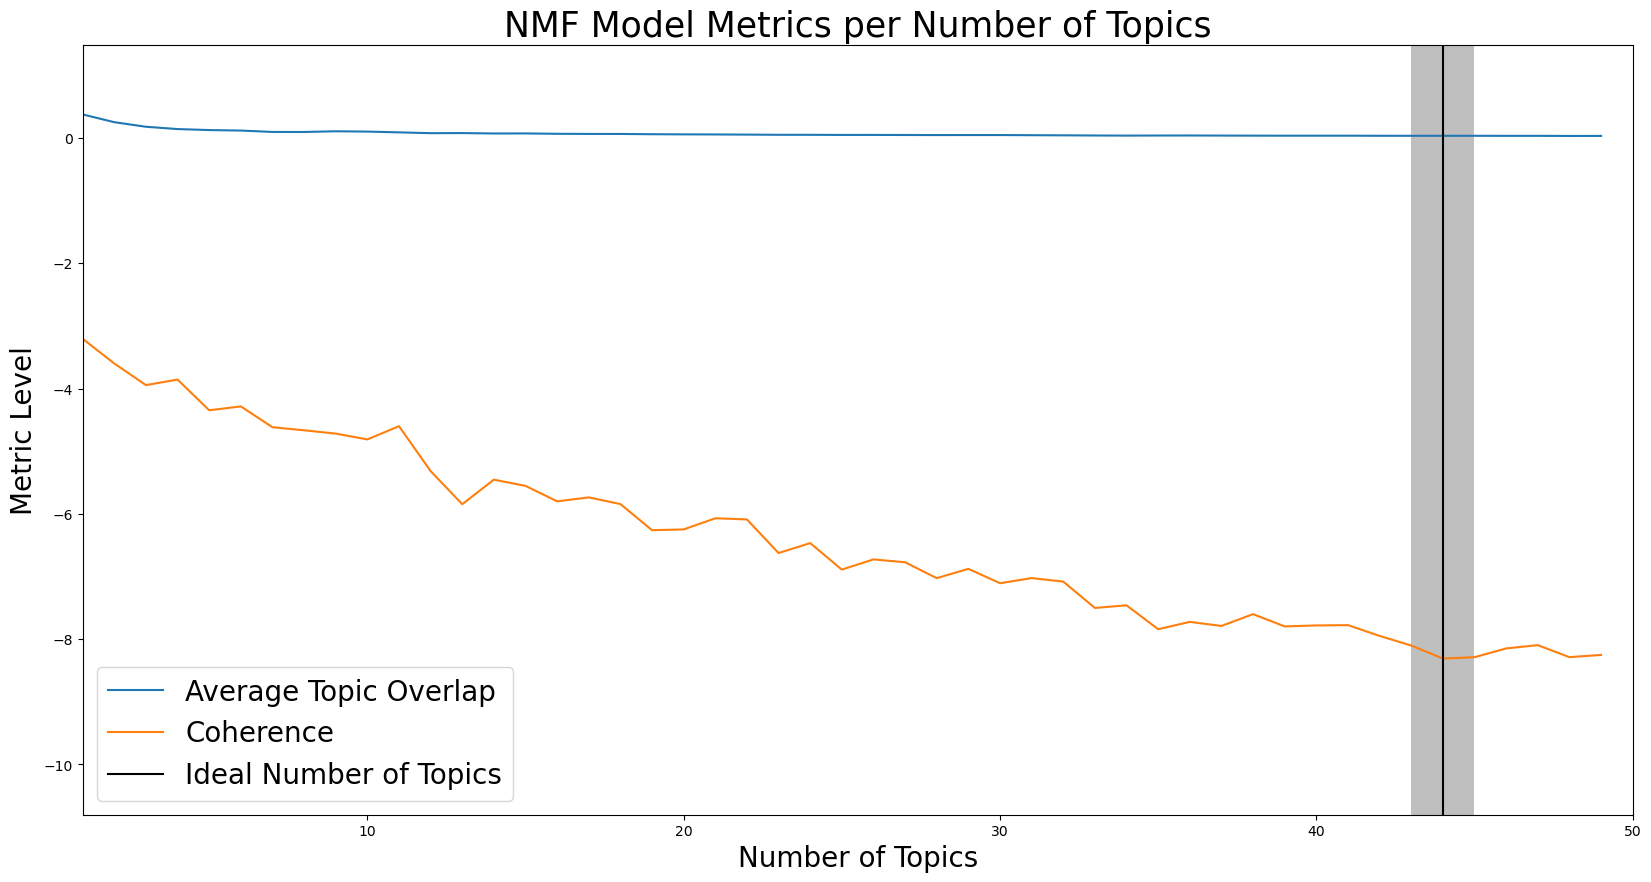

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt 

plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics_list[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics_list[:-1], y=coherence_nmf_list[:-1], label='Coherence')
# ax = sns.lineplot(x=num_topics_list[:-1], y=perplexity_nmf_list[:-1], label='Perplexity')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_min = min(min(mean_stabilities), min(coherence_nmf_list[:-1]))* 1.3
y_max = max(max(mean_stabilities), max(coherence_nmf_list[:-1]))* 1.3 + 1
ax.set_ylim([y_min, y_max])
ax.set_xlim([1, num_topics_list[-1]])
                
ax.axes.set_title('NMF Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()   

In [87]:

list_tmp = [(index, topic) for index, topic in enumerate(nmf_topics[44])]
for index, topic in list_tmp:
    print ('Topic: {} \nTopics: {}'.format(index, topic[:]))

Topic: 0 
Topics: ['love', 'follows', 'fall', 'sets', 'unexpected', 'triangle', 'business', 'falls', 'loss', 'college', 'romantic', 'falling', 'work', 'social', 'justice']
Topic: 1 
Topics: ['team', 'career', 'fight', 'story', 'documentary', 'life', 'journey', 'win', 'mysterious', 'soccer', 'turn', 'interviews', 'human', 'personal', 'football']
Topic: 2 
Topics: ['friends', 'best', 'help', 'friend', 'childhood', 'series', 'adventures', 'four', 'little', 'secrets', 'join', 'case', 'film', 'cop', 'fun']
Topic: 3 
Topics: ['two', 'find', 'take', 'become', 'couple', 'magical', 'young', 'brothers', 'drug', 'friends', 'powers', 'ways', 'one', 'trip', 'tragic']
Topic: 4 
Topics: ['series', 'take', 'evil', 'animated', 'reality', 'life', 'based', 'stories', 'action', 'quest', 'follows', 'aspiring', 'town', 'tv', 'history']
Topic: 5 
Topics: ['special', 'stand', 'two', 'teams', 'women', 'former', 'comedian', 'show', 'plans', 'student', 'battle', 'class', 'across', 'agent', 'make']
Topic: 6 
Topi

## BTM


In [26]:
import bitermplus as btm
from gensim import interfaces, utils, matutils
from gensim.matutils import (
    kullback_leibler, hellinger, jaccard_distance, jensen_shannon,
    dirichlet_expectation, logsumexp, mean_absolute_difference,
)

import tmplot as tmp

texts_list = []
for word in texts:
    texts_list.append((' ').join(word))
# PREPROCESSING
# Obtaining terms frequency in a sparse matrix and corpus vocabulary
X, vocabulary, vocab_dict = btm.get_words_freqs(texts_list)
tf = np.array(X.sum(axis=0)).ravel()
# Vectorizing documents
docs_vec = btm.get_vectorized_docs(texts_list, vocabulary)
docs_lens = list(map(len, docs_vec))
# Generating biterms
biterms = btm.get_biterms(docs_vec)


In [63]:
btm_models = {}
btm_topics = {}
coherence_btm_list = []
perplexity_btm_list = []
entropy_btm_list = []
phi_list = {}

for num_topics in num_topics_list:
    # Build NMF model
    model = btm.BTM(X, vocabulary, T=num_topics)
    btm_models[num_topics] = model
    model.fit(biterms, iterations = 15)
    p_zd = model.transform(docs_vec)
    perplexity = model.perplexity_
    coherence = model.coherence_
    coherence_btm_list.append(np.average(coherence))
    perplexity_btm_list.append(perplexity)
    entropy = btm.entropy(model.matrix_topics_words_)
    entropy_btm_list.append(entropy)
    phi_list[num_topics] = tmp.get_phi(model)
    print('num_topics:', num_topics, 'Coherence btm:', coherence_btm_list[num_topics - 1], 'Perplexity btm:', perplexity_btm_list[num_topics - 1], "Entropy btm:", entropy_btm_list[num_topics - 1])
    


100%|███████████████████████████████████| 8807/8807 [00:00<00:00, 158927.65it/s]


num_topics: 1 Coherence btm: -613.0735786423511 Perplexity btm: 4989.014874352441 Entropy btm: 1.972175754422576


100%|███████████████████████████████████| 8807/8807 [00:00<00:00, 151338.83it/s]


num_topics: 2 Coherence btm: -621.9560851539547 Perplexity btm: 4542.050851563677 Entropy btm: 4.691702638239248


100%|███████████████████████████████████| 8807/8807 [00:00<00:00, 137413.55it/s]


num_topics: 3 Coherence btm: -611.1375675180725 Perplexity btm: 4290.860790616238 Entropy btm: 3.6961471030759316


100%|███████████████████████████████████| 8807/8807 [00:00<00:00, 139441.22it/s]


num_topics: 4 Coherence btm: -625.077988133762 Perplexity btm: 3972.010955678589 Entropy btm: 3.2375463980236066


100%|███████████████████████████████████| 8807/8807 [00:00<00:00, 126779.06it/s]


num_topics: 5 Coherence btm: -627.1245433944362 Perplexity btm: 3853.485330169153 Entropy btm: 3.1705250127095383


100%|███████████████████████████████████| 8807/8807 [00:00<00:00, 126135.33it/s]


num_topics: 6 Coherence btm: -626.4897090670655 Perplexity btm: 3605.6674639424723 Entropy btm: 3.0277550103890336


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 92906.69it/s]


num_topics: 7 Coherence btm: -634.5079957723746 Perplexity btm: 3447.3405130773526 Entropy btm: 2.8086748647483506


100%|███████████████████████████████████| 8807/8807 [00:00<00:00, 114529.97it/s]


num_topics: 8 Coherence btm: -633.6023026395274 Perplexity btm: 3348.457286096151 Entropy btm: 2.753281509566014


100%|███████████████████████████████████| 8807/8807 [00:00<00:00, 108228.77it/s]


num_topics: 9 Coherence btm: -635.0234687370339 Perplexity btm: 3265.74109273074 Entropy btm: 2.7540866424113135


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 99617.42it/s]


num_topics: 10 Coherence btm: -632.9647273543775 Perplexity btm: 3187.669739405849 Entropy btm: 2.7922653145714857


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 95622.19it/s]


num_topics: 11 Coherence btm: -637.8916055823063 Perplexity btm: 3108.245966394449 Entropy btm: 2.8256714156929976


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 79176.83it/s]


num_topics: 12 Coherence btm: -639.3509024889859 Perplexity btm: 3034.4505265827174 Entropy btm: 2.8630182987922237


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 89046.25it/s]


num_topics: 13 Coherence btm: -637.8107672351952 Perplexity btm: 2972.4414478649 Entropy btm: 2.909272118375668


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 84581.98it/s]


num_topics: 14 Coherence btm: -635.6062673741468 Perplexity btm: 2927.8232258811117 Entropy btm: 2.9560099220631275


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 85912.79it/s]


num_topics: 15 Coherence btm: -640.3552041782639 Perplexity btm: 2806.929173865957 Entropy btm: 2.9993864054705237


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 83822.88it/s]


num_topics: 16 Coherence btm: -632.7908855049632 Perplexity btm: 2768.0895638093657 Entropy btm: 3.046919610119536


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 77755.03it/s]


num_topics: 17 Coherence btm: -646.8895545653015 Perplexity btm: 2710.8538068020493 Entropy btm: 3.0928446792135493


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 78841.04it/s]


num_topics: 18 Coherence btm: -644.321486861098 Perplexity btm: 2675.095736539901 Entropy btm: 3.1360387458535066


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 73917.20it/s]


num_topics: 19 Coherence btm: -652.6098252972563 Perplexity btm: 2648.8213058450424 Entropy btm: 3.1793289768859165


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 64478.64it/s]


num_topics: 20 Coherence btm: -648.229829135917 Perplexity btm: 2575.087669670356 Entropy btm: 3.219493483128139


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 64909.53it/s]


num_topics: 21 Coherence btm: -656.7905952850399 Perplexity btm: 2559.672736611901 Entropy btm: 3.25932950801469


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 62161.73it/s]


num_topics: 22 Coherence btm: -653.69037240635 Perplexity btm: 2506.803572085471 Entropy btm: 3.298524952120027


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 63225.48it/s]


num_topics: 23 Coherence btm: -647.9512678843988 Perplexity btm: 2454.394417429135 Entropy btm: 3.3343008906047684


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 63754.51it/s]


num_topics: 24 Coherence btm: -651.6076868901529 Perplexity btm: 2435.5587691781257 Entropy btm: 3.371528232284524


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 58367.44it/s]


num_topics: 25 Coherence btm: -652.6850810021878 Perplexity btm: 2379.201601007223 Entropy btm: 3.405773467885865


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 59469.68it/s]


num_topics: 26 Coherence btm: -654.8719298928179 Perplexity btm: 2343.4042482477184 Entropy btm: 3.43894558536749


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 55085.01it/s]


num_topics: 27 Coherence btm: -649.4816643153555 Perplexity btm: 2324.8442069191165 Entropy btm: 3.4715333810471813


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 52829.20it/s]


num_topics: 28 Coherence btm: -651.2205891581013 Perplexity btm: 2293.9200888781747 Entropy btm: 3.5030506402038877


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 54468.51it/s]


num_topics: 29 Coherence btm: -657.7618484412268 Perplexity btm: 2279.9948207375164 Entropy btm: 3.5337853100570156


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 53489.54it/s]


num_topics: 30 Coherence btm: -653.6122293041714 Perplexity btm: 2255.858629952426 Entropy btm: 3.563233240264805


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 53537.68it/s]


num_topics: 31 Coherence btm: -663.8720324124256 Perplexity btm: 2226.907637604109 Entropy btm: 3.5922083275104684


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 56925.84it/s]


num_topics: 32 Coherence btm: -659.8563778329074 Perplexity btm: 2197.597429442285 Entropy btm: 3.619918602835107


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 48515.46it/s]


num_topics: 33 Coherence btm: -658.8797921549893 Perplexity btm: 2162.6798420026466 Entropy btm: 3.646773238024637


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 49158.26it/s]


num_topics: 34 Coherence btm: -661.5841437039106 Perplexity btm: 2141.52161979745 Entropy btm: 3.6731977110927905


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 47230.89it/s]


num_topics: 35 Coherence btm: -661.2332803279065 Perplexity btm: 2114.3330790626655 Entropy btm: 3.6990545089189513


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 47269.45it/s]


num_topics: 36 Coherence btm: -655.3566552729199 Perplexity btm: 2091.9181251308178 Entropy btm: 3.7242859523801175


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 45471.73it/s]


num_topics: 37 Coherence btm: -674.0353624029545 Perplexity btm: 2083.523858946845 Entropy btm: 3.7487799932110937


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 41623.32it/s]


num_topics: 38 Coherence btm: -658.5439259414703 Perplexity btm: 2036.9372223645441 Entropy btm: 3.772311847108736


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 41404.36it/s]


num_topics: 39 Coherence btm: -661.6652151781005 Perplexity btm: 2037.9665643996996 Entropy btm: 3.795679366743074


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 40820.98it/s]


num_topics: 40 Coherence btm: -668.4837909948848 Perplexity btm: 2017.045703238611 Entropy btm: 3.818579872329647


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 40580.62it/s]


num_topics: 41 Coherence btm: -667.5814959038623 Perplexity btm: 1996.9756421226866 Entropy btm: 3.8404931975562926


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 40102.17it/s]


num_topics: 42 Coherence btm: -671.883786408995 Perplexity btm: 1963.1385849510314 Entropy btm: 3.8620717168434218


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 38947.85it/s]


num_topics: 43 Coherence btm: -670.5141750948119 Perplexity btm: 1940.2443494810154 Entropy btm: 3.883387960575758


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 38312.79it/s]


num_topics: 44 Coherence btm: -670.8733462049005 Perplexity btm: 1953.7473754335 Entropy btm: 3.904638595400799


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 37157.83it/s]


num_topics: 45 Coherence btm: -673.8474608465109 Perplexity btm: 1925.2654938778164 Entropy btm: 3.9247345084582337


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 37044.48it/s]


num_topics: 46 Coherence btm: -670.7930569604308 Perplexity btm: 1910.012466531048 Entropy btm: 3.9447500378375233


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 35915.67it/s]


num_topics: 47 Coherence btm: -674.0454513320138 Perplexity btm: 1882.4423830998196 Entropy btm: 3.9642590848420003


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 34704.93it/s]


num_topics: 48 Coherence btm: -668.1738479143651 Perplexity btm: 1869.9878699373269 Entropy btm: 3.9834957655019823


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 33574.93it/s]


num_topics: 49 Coherence btm: -672.0200424862677 Perplexity btm: 1846.0993037278483 Entropy btm: 4.0021505560161215


100%|████████████████████████████████████| 8807/8807 [00:00<00:00, 33804.82it/s]


num_topics: 50 Coherence btm: -667.8199596552839 Perplexity btm: 1849.1242417179853 Entropy btm: 4.02081855203143


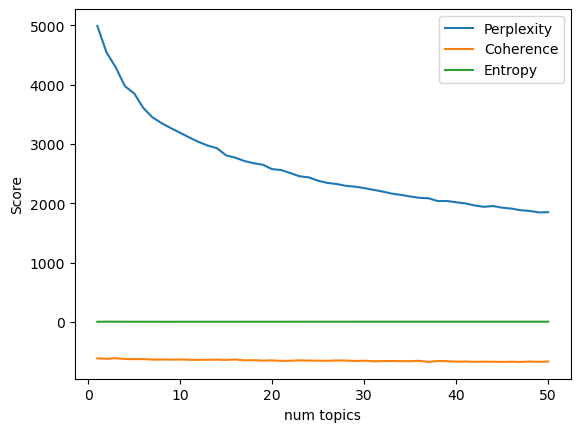

In [64]:
plt.plot(num_topics_list, perplexity_btm_list, label='Perplexity')
plt.plot(num_topics_list, coherence_btm_list, label='Coherence')
plt.plot(num_topics_list, entropy_btm_list, label='Entropy')
plt.xlabel('num topics')
plt.ylabel('Score')
plt.legend()
plt.show()

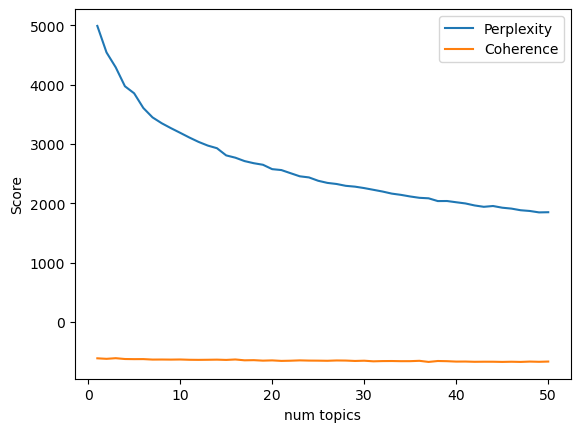

In [88]:
plt.plot(num_topics_list, perplexity_btm_list, label='Perplexity')
plt.plot(num_topics_list, coherence_btm_list, label='Coherence')
# plt.plot(num_topics_list, entropy_btm_list, label='Entropy')
plt.xlabel('num topics')
plt.ylabel('Score')
plt.legend()
plt.show()

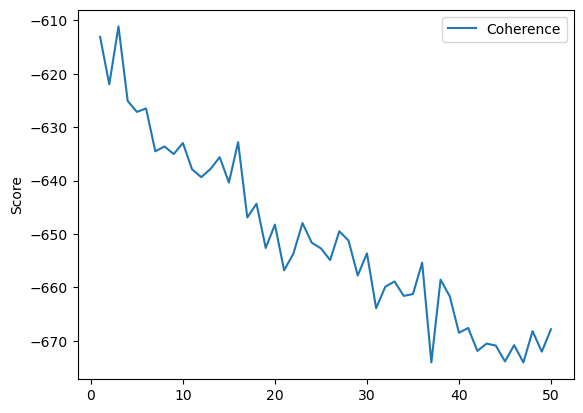

In [65]:
plt.plot(num_topics_list, coherence_btm_list, label='Coherence')
plt.ylabel('Score')
plt.legend()
plt.show()

In [66]:
max_coherence = max(coherence_btm_list)
index = coherence_btm_list.index(max(coherence_btm_list))
print(max_coherence, " at topic number = ", index+1)

-611.1375675180725  at topic number =  3


In [79]:
topic_num = 3
phi = phi_list[topic_num]

for i in phi.columns:
  top_words = phi.sort_values(by=i, ascending = False).head(num_keywords).index.tolist()
  word_results = ", ".join(top_words) 
  print(f"Topic {i}: {word_results}")

Topic 0: life, new, young, love, world, documentary, family, two, friends, series, woman, one, man, school, high
Topic 1: young, life, world, new, family, friends, man, two, must, series, woman, love, home, find, finds
Topic 2: life, young, man, family, new, two, woman, love, world, one, must, old, father, school, friends


In [68]:
texts = [" ".join(i) for i in data_words]
btm.get_top_topic_docs(texts, btm_models[topic_num].matrix_docs_topics_, num_keywords)

topic0  \
0   vice magazine andy capper follows rapper snoop...   
1   directors emmy nominated lust stories zoya akh...   
2   recipe life star rafał rutkowski comedy lab ol...   
3   brazilian rapper emicida brings progressive rh...   
4   celebration groundbreaking comedy show laugh s...   
5   depth look full cycle breeding program bluefin...   
6   first kind uhd clearest picture available real...   
7   gigi avant garde french waif groomed fille de ...   
8   storm wrecks ship super strong sailor popeye w...   
9   learn basics rights citizenship upbeat songs p...   
10  italian comic satirist saverio raimondo regale...   
11  illusionist derren brown reinvents concept fai...   
12  romanticized life media mogul assis chateaubri...   
13  sing along dance bailey franny kip lulu tilly ...   
14  chats host rasika dugal mythologist devdutt pa...   

                                               topic1  \
0   lifting saggy skin repairing shoddy breast enh...   
1   kari byron tory belleci grant imahara rank his...   
2   fred armisen carrie brownstein send residents ...   
3   mind fogged scimitar weilding stranger mayuri ...   
4   hyper hedgehog sonic cohort miles tails prower...   
5   seiya knights zodiac rise protect reincarnatio...   
6   charismatic highwayman jan de lichte leads opp...   
7   wicked undead army unleashed sorceress udonna ...   
8   veteran television newsman edward murrow faces...   
9   subterranean worm like creatures back graboid ...   
10  refreshing flavorful naengmyeon korea coolest ...   
11  examine troublesome coexistence humans rodents...   
12  historian suzannah lipscomb investigates witch...   
13  irreverent sitcom featues ludovico federica th...   
14  heirless maharaj brajbhan leaves throne cousin...   

                                               topic2  
0   milos knor brings comedians lukas pavlasek tom...  
1   st bernard beethoven sires brood missy newton ...  
2   serving marshal rowdy abilene kansas wild bill...  
3   refusing accept death sentence doctor diagnose...  
4   songstress sisters toni traci towanda trina ta...  
5   intimate portrait sheds light trauma experienc...  
6   casting light mistreatment sea mammals documen...  
7   sultan egypt syria launches campaign retake je...  
8   chilean comedian personality jani duenas pours...  
9   explore mainstream media often disparaging por...  
10  arbitration panel formed company ceo nigeria s...  
11  blending fact myth conspiracy minded docuficti...  
12  marlon brando gives nuanced performance aristo...  
13  leading astronomers reveal latest discoveries ...  
14  tales eccentric aristocrat tightrope walking n...

## CorEx

In [71]:
import numpy as np
import scipy.sparse as ss
from corextopic import corextopic as ct
import corextopic.vis_topic as vt # jupyter notebooks will complain matplotlib is being loaded twice

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline


In [72]:
vect = CountVectorizer(stop_words=stop_words, analyzer='word', ngram_range=(1,1), min_df = 0.01)
X = vect.fit_transform([" ".join(i) for i in data_words])
X = ss.csr_matrix(X)


In [75]:
corex_models = {}
coherence_corex_list = []
perplexity_corex_list = []

for num_topics in num_topics_list:
    # Build CorEx model
    model = ct.Corex(n_hidden=num_topics, verbose = False)
    corex_models[num_topics] = model
    
    words = vect.get_feature_names()
    model.fit(X, words = words, anchors=None)
    
    coherence_corex_list.append(model.tc)
    
    print('num_topics:', num_topics, 'CorEx Total Coherence:', coherence_corex_list[num_topics - 1])
    

num_topics: 1 CorEx Total Coherence: 0.1920098432724213
num_topics: 2 CorEx Total Coherence: 0.21072047861026352
num_topics: 3 CorEx Total Coherence: 0.2284234513183209
num_topics: 4 CorEx Total Coherence: 0.2692229274506399
num_topics: 5 CorEx Total Coherence: 0.26339457351559575
num_topics: 6 CorEx Total Coherence: 0.34299677722899896
num_topics: 7 CorEx Total Coherence: 0.3232717140151209
num_topics: 8 CorEx Total Coherence: 0.334500876918458
num_topics: 9 CorEx Total Coherence: 0.30519154916720764
num_topics: 10 CorEx Total Coherence: 0.33977198828525285
num_topics: 11 CorEx Total Coherence: 0.3000058592228862
num_topics: 12 CorEx Total Coherence: 0.37543984137771635
num_topics: 13 CorEx Total Coherence: 0.3020598508250663
num_topics: 14 CorEx Total Coherence: 0.33992830952265224
num_topics: 15 CorEx Total Coherence: 0.34605679935101574
num_topics: 16 CorEx Total Coherence: 0.3233625063420719
num_topics: 17 CorEx Total Coherence: 0.333783501720305
num_topics: 18 CorEx Total Coheren

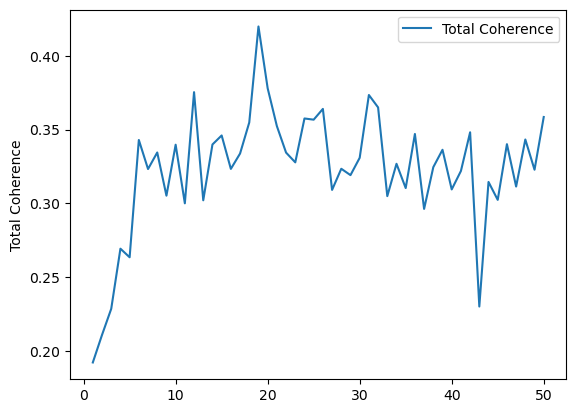

In [76]:
plt.plot(num_topics_list, coherence_corex_list, label='Total Coherence')
plt.ylabel('Total Coherence')
plt.legend()
plt.show()

In [78]:
max_coherence = max(coherence_corex_list)
index = coherence_corex_list.index(max_coherence)
print(max_coherence, " at topic number = ", index+1)

0.42000244879945053  at topic number =  19


In [89]:
topic_num = 19
corex_topics = corex_models[topic_num].get_topics()
for topic_idx,topic in enumerate(corex_topics):
#     topic = [w if s > 0 else ('~'+w) for w,_,s in topic]
    topic = [w for w,_,s in topic]
    results = ", ".join(topic[:num_keywords])
    print(f"Topic {topic_idx}: {results}")

Topic 0: school, high, students, student, college, teen, girl, gets, people, group
Topic 1: true, based, story, events, real, drama, come, series, dreams, stories
Topic 2: stand, special, comedy, comedian, comic, show, sex, set, first, mysterious
Topic 3: old, year, boy, us, reality
Topic 4: new, york, city, finds, home, soon
Topic 5: town, small, village, secrets, film, turn
Topic 6: woman, young, father, son, mother, husband, daughter, history, goes
Topic 7: friend, best, friends, childhood, get, trip, one, go, become
Topic 8: police, cop, murder, detective, crime, killer, drug, gang, death, social
Topic 9: women, different, men, lives, two, three, four, discover, together, try
Topic 10: love, couple, marriage, romance, relationship, single, meets, mission, team, wealthy
Topic 11: save, evil, earth, back, fight, time, career, kids, personal, day
Topic 12: man, brother, wife, ex, falls, returns, family, five, girlfriend, band
Topic 13: documentary, must, follows, find, dark, secret, k

In [ ]:
# Get 20 newsgroups data
newsgroups = fetch_20newsgroups(subset=)
# Transform 20 newsgroup data into a sparse matrix
vectorizer = CountVectorizer(stop_words='english', max_features=20000, binary=True)
doc_word = vectorizer.fit_transform(newsgroups.data)
doc_word = ss.csr_matrix(doc_word)
# Get words that label the columns (needed to extract readable topics and make anchoring easier)
words = list(np.asarray(vectorizer.get_feature_names()))
not_digit_inds = [ind for ind,word in enumerate(words) if not word.isdigit()]
doc_word = doc_word[:,not_digit_inds]
words    = [word for ind,word in enumerate(words) if not word.isdigit()]
